# SLT-CE-5: Pairwise Clustering

In [ ]:
#

In this coding exercise you will apply pairwise clustering for proximity data and you will see how to use the mean-field approximation (MFA) approach with the EM-algorithm to get a labeling for a data object encoded by similarity and dissimilarity matrices. You will also be able to implement modifications of the EM-scheme to obtain embeddings into an Euclidean space.

<b> References: </b>

[1] T. Hoffman, JM Buhmann. Pairwise Data Clustering by Deterministic Annealing, 1996: http://citeseerx.ist.psu.edu/viewdoc/download?doi=10.1.1.8.9812&rep=rep1&type=pdf 

Optionally, the following resources could be helpful:

[2] Lecture 7. Pairwise clustering: https://ml2.inf.ethz.ch/courses/slt/lectures/slt20_lecture07.pdf

[3] Lecture script. Chapter 3.2: https://ml2.inf.ethz.ch/courses/slt/tutorials/SLT_Script.pdf

[4] Lecture 4. Determenistic Annealing: https://ml2.inf.ethz.ch/courses/slt/lectures/slt20_lecture04.pdf

[5] Lecture 8. Mean-field approximation: https://ml2.inf.ethz.ch/courses/slt/lectures/slt20_lecture08.pdf

<h2 style="background-color:#f0b375;"> Setup </h2>

In [1]:
import sklearn as skl
import matplotlib.pyplot as plt
import numpy as np
import scipy as sp
import pandas as pd
import sys
from scipy.stats import mode
import warnings
warnings.filterwarnings('ignore')

from sklearn.utils.validation import check_is_fitted
from sklearn.cluster import SpectralClustering
from scipy.io import loadmat

#Please use this seed in all sections, except section 5.5
np.random.seed(111)

<h2 style="background-color:#f0b375;"> Data </h2>

## ProDom Data

ProDom is a comprehensive set of protein domain families [6]. A ProDom subset of 2604 protein domain sequences from the ProDom set was selected by [7]. These are chosen based on a high similarity to at least one sequence contained in the first four folds of the SCOP database. The pairwise structural alignments are computed [7]. Each SCOP sequence belongs to a group, as labeled by the experts [8]. The same four classes are assigned here.

<b> References: </b>

[6] F. Corpet, F. Servant, J. Gouzy and D. Kahn, ProDom and ProDom-CG: tools for protein domain analysis and whole genome comparisons, Nucleid Acids Res., vol. 28, 267-269, 2000.

[7] V. Roth, J. Laub, J.M. Buhmann, and K.-R. Mueller, Going metric: Denoising pairwise data, Advances in Neural Information Processing Systems, 841-856, MIT Press, 2003.

[8] A.G. Murzin, S.E. Brenner, T. Hubbard and C. Chothia, SCOP: a structural classification of proteins database for the investigation of sequences and structures, Journal of Molecular Biology, vol. 247, 536-540, 1995.


Download link: http://prtools.org/disdatasets/index.html#ProDom

In [2]:
prodom = {"input": loadmat("prodom.mat")}
# After some reverse-engineering:
prodom["similarity"] = np.array(prodom["input"]["s"])[0,0][0]
prodom["labels"] =np.array(prodom["input"]["s"])[0,0][2].flatten()

## Protein Data

The protein data are provided as a 213x213 dissimilarity matrix comparing the protein sequences based on the concept of an evolutionary distance. It was used for classification in [9] and for clustering in [10]. There are four classes of globins: heterogeneous globin (G), hemoglobin-A (HA), hemoglobin-B (HB) and myoglobin (M). Each protein in the dataset is classified into one of these four classes.

<b> References: </b>

[9] T. Graepel, R. Herbrich, P. Bollmann-Sdorra, K. Obermayer, Classification on pairwise proximity data. In Advances in Neural Information System Processing vol. 11, 438-444, 1999.

[10] T. Denoeux, T. and M.-H. Masson, EVCLUS: Evidential clustering of proximity data. IEEE Transations on Systems, Man and Cybernetics, vol. 34, 95-109, 2004.

Download link (use The PRTools version of Protein): http://prtools.org/disdatasets/index.html#Protein

In [3]:
protein = {"input": loadmat("protein.mat")}
protein["dissimilarity"] = np.array(protein["input"]["d"])[0,0][0]
protein["labels"] =np.array(protein["input"]["d"])[0,0][2].flatten()

<h2 style="background-color:#f0b375;">
Section 4.0 
<span style=font-size:50%> Complete all problems (4.0.1-4.0.9) in this section to get a pass on this exercise. </span>
</h2>

In this section, you have to give a description of the pairwise clustering approach based on deterministic annealing and mean-field approximation. Then you have to implement it, as described in Algorithm II in reference [1].


<p style="background-color:#adebad;"> 
<b>NOTE</b>: Please follow these guidelines: <br>
</p>
<ul style="background-color:#adebad;"> 
<li> Use consistent notation throughout the notebook. </li>
<li> Define every variable properly. </li>
<li> Define every math notation before usage. </li>
<li> Use math mode with $$ for formulas. </li>
</ul>


<p style="background-color:#adebad;">
    1. Implement the function <b>plot_pairwise()</b> according to its docstring. Hint: <b>usematplotlib.pyplot.matshow()</b> to visualize matricies, <b>matplotlib.pyplot.axhspan(),matplotlib.pyplot.axvspan()</b> to add horizontal and vertical rectangles to the plot.
</p>

In [4]:
def plot_pairwise(data, labels, cmap="binary", alpha=0.33):
    """Plot (dis-)similarity data
    
    Args:
        data (np.ndarray): Symmetric (dis-)similarity array (n_samples, n_samples)
        labels (np.array): Cluster label array  (n_samples,)
        cmap (str): Color Map for (dis-)similarity values. Please use matplotlib colormaps. See here for details: 
        https://matplotlib.org/tutorials/colors/colormaps.html
        alpha (float): Opacity of cluster overlay, between 0 and 1
        
    Shows:
        Image plot of (dis-)similarity matrix, overlaid with transparent blocks,
        which indicate the clusters contained in labels.
        Note: Permute the data according to the sorting of the labels.
        
    Prints:
        Minimum, Maximum and Median of (dis-)similarity values
        Warning, if (dis-)similarity matrix is not symmetric
        
    Returns:
        This is void function. No return required.
    """
   
       # Indexes of the sorted labels (clusters)
    idx    = labels.argsort(kind="stable")
    labels = labels[idx]
    
    _, cnt = np.unique(labels, return_counts=True)
    util   = np.cumsum(cnt)
    util_n = util/util[-1]
    
    # Permute (dis)similarity matrix according to the labels
    P   = data[:, idx]
    P   = P[idx,:]
    
    print("data.min = {}".format(np.min(P)))
    print("data.median = {}".format(np.median(P)))
    print("data.max = {}".format(np.max(P)))
    
    # Plot the (dis)similarity matrix
    fig, ax = plt.subplots()
    ax.matshow(P, cmap=cmap)
    ax.axhspan(0, util[0], xmin=0, xmax=util_n[0], facecolor='green', alpha=alpha*0.2)
    ax.axhspan(util[0], util[1], xmin=util_n[0], xmax=util_n[1], facecolor='yellow', alpha=alpha*0.2)
    ax.axhspan(util[1], util[2], xmin=util_n[1], xmax=util_n[2], facecolor='cyan', alpha=alpha*0.2)
    ax.axhspan(util[2], util[3], xmin=util_n[2], xmax=1, facecolor='blue', alpha=alpha*0.2)
    
    ax.set_ylim(util[-1], 0)
    plt.show()
    
    return

data.min = -15529
data.median = -8847.0
data.max = 478835


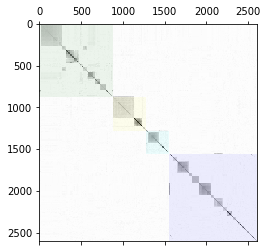

In [5]:
#Example how output should looks like after the following command
plot_pairwise(prodom["similarity"], prodom["labels"])

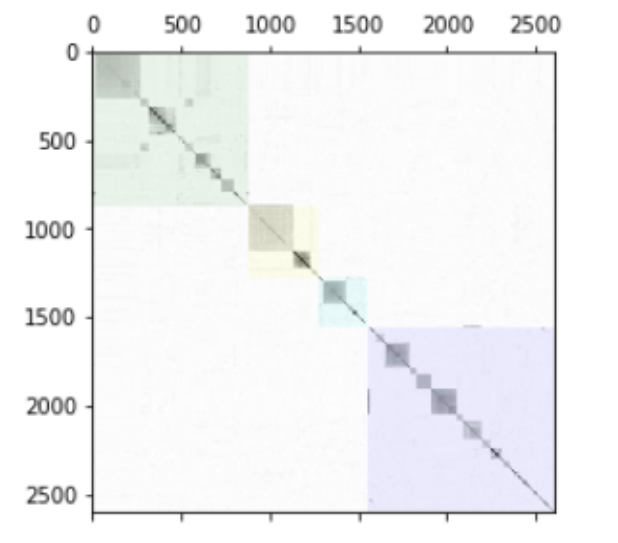

<p style="background-color:#adebad;">
    2. Demonstrate your implementation of <b> plot_pairwise() </b> below.
</p>

data.min = 0.0
data.median = 11.23
data.max = 13.64


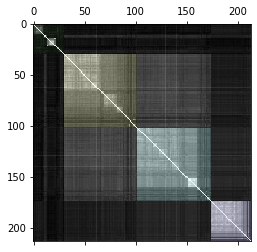

In [6]:
plot_pairwise(protein["dissimilarity"], protein["labels"])

<p style="background-color:#adebad;">
Read reference [1] and answer the following questions:
</p>
<p style="background-color:#adebad;">
3. Provide a description of the general EM algorithm with main formulas. <br>
</p>

The EM algorithm includes two calculations and can be summarized as below:

1) Firstly, we determine some parameters like initial and final temperature etc.

2) Secondly, we initialize the optimal potentials $\varepsilon^*_{iv}$ and expected assignment probabilities $M_{iv}\in (0,1)$ and both have the shape ($N\times K$) where $N$ is the number of samples and $K$ is the number of clusters.

3) Then, while final temperature $T_f$ is lower than current temperature $T$:
 
-  Calculate new assignment probabilities $M_{iv}$ and as a function of current potentials $\varepsilon^*_{iv}$.

- Calculate new optimal potentials $\varepsilon^*_{iv}$ and as a function of current assignments $M_{iv}$.

- Do the above two steps until they converge, stop for example when Frobenius norm of the difference between new assignment probabilities and the old one is lower than a threshold. 

- Update the temperature as $T=T/2$, update the current assignments and potentials with the new ones and go back to the first step.
- **Formulas**: Formulas for calculating the variables above can be seen below:


1) $$ M_{i \alpha} = \frac{\exp(-\varepsilon^*_{i\alpha} / T) }{\sum^{K}_{v=1} \exp(-\varepsilon^*_{iv} / T)} $$


2)  $$ \varepsilon_{iv}^{*} = \frac{1}{p_vN} \sum_{k=1}^{N} M_{kv} \bigg( D_{ik} - \frac{1}{2p_vN} \sum_{j=1}^N M_{jv}D_{jk} \bigg) $$

where 

$$ p_v =\frac{\sum_{k=1}^{N} M_{kv}}{N}$$


3) $$ X_i = K_i^{-1} \frac{1}{2} \sum_{v=1}^K M_{iv} \big( ||y_v||^2 - \varepsilon^*_{iv} \big) \big(y_v - \sum_{\mu =1}^K M_{i\mu} y_{\mu}\big)$$

$$ y_v = \frac{\sum_{k=1}^N M_{kv} x_k}{\sum_{k=1}^N M_{kv}}$$

where 

$$ K_i = \bigg(<yy^T>_i - <y>_i<y^T>_i \bigg) $$

<p style="background-color:#adebad;">
4. Why is it not possible to apply the EM-scheme for central clustering (algorithm I in [1]) to the case of pairwise clustering? <br>
</p>

 Algoritm III has the same EM-like procedure above with some additions and can be summarized as below:

1) Firstly, we determine some parameters like initial and final temperature etc.

2) Secondly, we initialize the embeddings $\hat{\mathbf{x}}_i$ with the shape ($N\times D$), centroids $\hat{\mathbf{y}}_v$ with the shape ($K\times D$) and the expected assignment probabilities $M_{iv}\in (0,1)$ with the shape ($N\times K$) where $N$ is the number of samples, $K$ is the number of clusters and $D$ is the number of dimensions of the embeddings.

3) Then, while final temperature $T_f$ is lower than current temperature $T$:
 
- Calculate new assignment probabilities $M_{iv}$ as a function of $\hat{\mathbf{x}}_i$ and $\hat{\mathbf{y}}_v$, where $\hat{\mathbf{y}}_v$ corresponds to the centroids.

- Until centroids converge; first calculate new embeddings $\hat{\mathbf{x}}_i$ with the new $M_{iv}$ and current $\hat{\mathbf{y}}_v$ and then find the new centroids by updating $\hat{\mathbf{y}}_v$ to fulfill centroid condition.

- Do the above two steps until they converge, stop for example when Frobenius norm of the difference between new assignment probabilities and the old one is lower than a threshold. 

- Update the temperature as $T=T/2$, update the current assignments, embeddings and centroids with the new ones and go back to the first step.

<p style="background-color:#adebad;">
5. Describe the idea of mean-field approximation (as KL divergency minimization problem) with the main formulas. How does mean field approximaiton help to solve the problem from the previous question?<br>
</p>

In [ ]:
#Provide your answer here

<p style="background-color:#adebad;">
6. Provide a description of the EM algorithm for pairwise clustering for the case if we have proximity data (algorithm II in [1]). <br>
</p>

The following approach can be summarized as below:

1) Firstly, we determine some parameters like initial and final temperature etc.

2) Secondly, we initialize the optimal potentials $\varepsilon^*_{iv}$ with the shape ($N\times K$), the embeddings $\hat{\mathbf{x}}_i$ with the shape ($N\times D$), centroids $\hat{\mathbf{y}}_v$ with the shape ($K\times D$) and the expected assignment probabilities $M_{iv}\in (0,1)$ with the shape ($N\times K$) where $N$ is the number of samples, $K$ is the number of clusters and $D$ is the number of dimensions of the embeddings.

3) Then, while final temperature $T_f$ is lower than current temperature $T$:
 
- Calculate new assignment probabilities $M_{iv}$ and as a function of current potentials $\varepsilon^*_{iv}$.

- Calculate new optimal potentials $\varepsilon^*_{iv}$ and as a function of current assignments $M_{iv}$.

- Do the above two steps until they converge, stop for example when Frobenius norm of the difference between new assignment probabilities and the old one is lower than a threshold. Update the current assignments and potentials with the new ones.

- Until centroids converge; first calculate the new centroids $\hat{\mathbf{y}}_v$ with $M_{iv}$ and $\hat{\mathbf{x}}_i$ and then calculate the new embeddings using new $\hat{\mathbf{y}}_v$.

- Update the temperature as $T=T/2$ and go back to the first step.

<p style="background-color:#adebad;">   
7. Implement the <b>fit_predict()</b> method without embedding (Algorithm II in [1]) for the template <b>class PairwiseClustering</b>, according to its docstring. You can add more class methods if necessary <br>
</p>

In [11]:
class PairwiseClustering(skl.base.BaseEstimator, skl.base.TransformerMixin):
    """Template class for PairwiseClustering (PC)
    
    Attributes:
        M (np.ndarray): Assignment probability matrix (n_samples, n_clusters)
        centroids (np.ndarray): Embedding centroids (n_clusters, n_components), used only if embed is True.
        embeddings (np.ndarray): Embeddings of input samples (n_samples, n_components),
                                 used only if embed is True.
    Parameters:
        n_clusters (int): Maximum number of clusters.
        random_state (int): Random seed.
        embed (bool): Indicator, if data should be clustered and embedded simultaneously (algorithm III),
                      or not (algorithm II).
        n_components (int): Dimension of embedding space, used only if embed is True
    """
    
    def __init__(self, n_clusters=4, random_state=1, embed=False, n_components=2, T=1, T_f=0.0001, eps=1e-4, rate=0.5, eps_embed=0.05):
        self.n_clusters = n_clusters
        self.random_state = random_state
        self.embed = embed
        self.n_components = n_components
        self.T = T
        self.T_f = T_f
        self.eps = eps
        self.rate = rate
        self.M = None
        self.eps_embed = eps_embed
        # Add more parameters, if necessary.
    
    def fit_predict(self, X):
        """Compute PC for dissimilarity matrix X
        
        Compute cluster assignments. If embed is True, also compute embeddings/centroids.
         
        Args:
            X (np.ndarray): Dissimilarity matrix (n_samples, n_samples)
        
        Returns:
            C (np.ndarray): Assignments (n_samples,) 
        """
        np.random.seed(self.random_state)
        
        if self.embed:
            n_samples    = X.shape[0]
            n_clusters   = self.n_clusters
            n_components = self.n_components
            
            # Useful parameters like initial-final temperature and convergence point
            T    = self.T     #Initial temperature
            T_f  = self.T_f   #Final temperature
            eps  = self.eps   #Convergence value
            rate = self.rate  #Temperature decrease rate
            
            # Initialization of the potentials, assignments, embeddings etc.
            D   = X.copy()
            E   = np.random.uniform(0, 1, size=(n_samples, n_clusters))
            M   = np.random.uniform(0, 1, size=(n_samples, n_clusters))
            X   = np.random.uniform(0, 1, size=(n_samples, n_components))
            y   = np.zeros((n_clusters, n_components))
            
            while T>T_f:
                # EM-like algorithm 
                while True:
                    M_old = M.copy()
                    ## E-like step:
                    # Exponential trick to prevent numerical errors        
                    norms    = -E / T
                    max_norm = np.amax(norms, axis=1)[:, np.newaxis]

                    # Calculation of optimal assignments
                    M = np.exp((-E / T)-max_norm)
                    M = M / (np.sum(M, axis=1)[:, np.newaxis])
                    
                    ## M-like step:
                    # Calculation of expected assignment variables
                    p_v = (np.sum(M, axis=0)/n_samples)[:, np.newaxis]
                    
                    # Calculation of optimal potentials for each cluster
                    for cluster in range(n_clusters):
                        M_c   = ((M[:, cluster])[:, np.newaxis]).T
                        temp1 = (1 / (2*p_v[cluster]*n_samples)) * (M_c @ D)
                        temp2 = M_c * (D - temp1) * (1 / (p_v[cluster]*n_samples))
                        E[:, cluster] = np.sum(temp2, axis=1)

                    ## Break the loop if optimal assignments and potentials don't change for the current temperature
                    if(np.linalg.norm(M-M_old) < eps): 
                        break
                        
                # EM-like algorithm for centroids and embeddings
                while True:
                    y_old = y.copy()
                    
                    # Calculation of centroids
                    for c in range(n_clusters):
                        y[c, :] = np.sum((M[:, c])[:, np.newaxis] * X, axis=0) / np.sum(M[:, c])
                    
                    # Calculation of embeddings
                    for i in range(n_samples):
                        # Calculate K_i
                        K       = np.cov(y, rowvar=False, ddof=0, aweights=M[i,:])
                        # Calculate the terms of K_i*x_i
                        tmp1    = y - (M[i, :] @ y)[np.newaxis, :]
                        tmp2    = np.diag(y@y.T)[:, np.newaxis] - E[i, :][:, np.newaxis]
                        tmp3    = M[i, :][:, np.newaxis] * 0.5
                        # Calculate K_i*x_i
                        K_X     = np.sum(tmp3 * (tmp2 * tmp1), axis=0)
                        # Calculate x_i
                        X[i, :] = np.linalg.inv(K) @ K_X
                    
                    # Normalize x_i
                    X = X / n_samples
                    
                    # Break the loop if centroids converge
                    if(np.linalg.norm(y-y_old) < self.eps_embed): 
                        for c in range(n_clusters):
                            y[c, :] = np.sum((M[:, c])[:, np.newaxis] * X, axis=0) / np.sum(M[:, c])
                        break
                        
                ## Update the temperature 
                T = T*rate
            
            # Store the necessary attributes
            self.X = X
            self.y = y
            self.M = M
            C = np.argmax(M, axis=1)
                          
            return C
        
        else:
            n_samples  = X.shape[0]
            n_clusters = self.n_clusters
            
            # Useful parameters like initial-final temperature and convergence point
            T    = self.T     #Initial temperature
            T_f  = self.T_f   #Final temperature
            eps  = self.eps   #Convergence value
            rate = self.rate  #Temperature decrease rate
            
            # Initialization of the potentials and assignments
            E   = np.random.uniform(0, 1, size=(n_samples, n_clusters))
            M   = np.random.uniform(0, 1, size=(n_samples, n_clusters))
            
            
            # EM-like algorithm
            while T>T_f:
                while True:
                    M_old = M.copy()
                    ## E-like step:
                    # Exponential trick to prevent numerical errors        
                    norms    = -E / T
                    max_norm = np.amax(norms, axis=1)[:, np.newaxis]

                    # Calculation of optimal assignments
                    M = np.exp((-E / T)-max_norm)
                    M = M / (np.sum(M, axis=1)[:, np.newaxis])
                    
                    ## M-like step:
                    # Calculation of expected assignment variables
                    p_v = (np.sum(M, axis=0)/n_samples)[:, np.newaxis]
                    
                    # Calculation of optimal potentials for each cluster
                    for cluster in range(n_clusters):
                        M_c   = ((M[:, cluster])[:, np.newaxis]).T
                        temp1 = (1 / (2*p_v[cluster]*n_samples)) * (M_c @ X)
                        temp2 = M_c * (X - temp1) * (1 / (p_v[cluster]*n_samples))
                        E[:, cluster] = np.sum(temp2, axis=1)

                    ## Break the loop if optimal assignments and potentials don't change for the current temperature
                    if(np.linalg.norm(M-M_old) < eps): 
                        break
                        
                ## Update the temperature        
                T = T*rate
            
            # Store the necessary attributes
            self.M = M
            C = np.argmax(M, axis=1)
                  
            return C
    
    
    def cost(self, D, M):
        """Compute the costs of the clustering solution M for dissimilarity D.
        
        The costs refer to the pairwise clustering costs in eq. (16) of reference [1].
        
        Args:
            D (np.ndarray): Dissimilarity matrix (n_samples, n_samples)
            M (np.ndarray): Assignment probability matrix (n_samples, n_clusters)
            
        Returns:
            cost (float): Costs of current clustering
        """
        
        # Necessary variables
        n_samples = D.shape[0]
        C         = np.argmax(M, axis=1)      
        p_v       = np.zeros((self.n_clusters,))
        
        ## Cost calculation:
        for c in range(self.n_clusters):
            p_v[c] = np.sum(C==c)/n_samples
        
        s = np.zeros((n_samples, n_samples))
        for c in range(self.n_clusters):
            tmp = ((C==c)*1)[:, np.newaxis] @ ((C==c)*1)[np.newaxis, :]
            s   = s + tmp*(1/p_v[c])
                
        cost = np.sum((s - 1) * D / (2*n_samples))
                
        return cost

<p style="background-color:#adebad;">
8. Create an instance of your Pairwise Clustering (PC) class, then fit and predict the Protein data. <br>
9. Record the execution time.
</p>

In [15]:
%%time
PC = PairwiseClustering()
labels_pair = PC.fit_predict(protein["dissimilarity"])

CPU times: user 1.07 s, sys: 8.06 ms, total: 1.08 s
Wall time: 312 ms


In [14]:
%%time
SC = skl.cluster.SpectralClustering(n_clusters=4, random_state=42, affinity="precomputed")
affinities = np.exp(- protein["dissimilarity"] / 3) # SC takes positive affinities as input
labels_spectral= SC.fit_predict(affinities)

CPU times: user 224 ms, sys: 77.3 ms, total: 302 ms
Wall time: 551 ms


<h2 style="background-color:#f0b375;">
Section 4.5 
<span style=font-size:50%> Complete all problems in this (4.5.1-4.5.5) and previous sections to get a grade of 4.5 </span>
</h2>

In this section, you have to compare pairwise clustering with another clustering approach, that also works with proximity data, in terms of different metrics.

<p style="background-color:#adebad;">
1. Read https://scikit-learn.org/stable/modules/clustering.html#spectral-clustering and shortly recap the idea of spectral clustering.
</p>

In [16]:
#Provide your answer here
from sklearn.cluster import SpectralClustering

<p style="background-color:#adebad;">
2. Predict the Protein data with sklearn.SpectralClustering. <br>
3. Record the execution time. <br>
</p>

In [17]:
%%time
SC = skl.cluster.SpectralClustering(n_clusters=4, random_state=42, affinity="precomputed")
affinities = np.exp(- protein["dissimilarity"] / 3) # SC takes positive affinities as input
labels_spectral= SC.fit_predict(affinities)

CPU times: user 58.3 ms, sys: 3.63 ms, total: 61.9 ms
Wall time: 56.1 ms


<p style="background-color:#adebad;">
4. Complete the function <b>compare_clusterings()</b> and use it to compare the spectral and the pairwise clustering methods. <br>
Use the following metrics to compare clusterings:
</p>
<ul style="background-color:#adebad;"> 
<li> V-measure cluster labeling given a ground truth. </li>
<li> Normalized Mutual Information between two clusterings. </li>
<li> Homogeneity metric of a cluster labeling given a ground truth. </li>
<li> The Fowlkes-Mallows score </li>
<li> Rand index adjusted for chance. </li>
<li> Adjusted Mutual Information between two clusterings. </li>
</ul>
<p style="background-color:#adebad;">
Hint: use <b>sklearn.metrics.v_measure_score(),sklearn.metrics.normalized_mutual_info_score(), sklearn.metrics.homogeneity_score(), sklearn.metrics.fowlkes_mallows_score(), sklearn.metrics.completeness_score(), sklearn.metrics.adjusted_rand_score(), sklearn.metrics.adjusted_mutual_info_score()</b>. You can also find explanations and examples there: https://scikit-learn.org/stable/modules/classes.html?highlight=metrics#module-sklearn.metrics
</p>

In [18]:
## This part is just for creating proper legend labels
def toLabel(key):
    if(len(key) > 19):
        res = key[20:]
        if res == "1":
            return "a=1"
        elif res == "2":
            return "a=2"
        elif res == "1_2":
            return "a=1/2"
        elif res == "log":
            return "a=log"
        elif res ==  "exp":
            return "a=exp"
        elif res == "Transform1":
            return "Best of Transform 1"
        elif res == "Transform2":
            return "Best of Transform 2"
        elif res == "Transform3":
            return "Best of Custom Transform"
    else:
        return key

In [19]:
def compare_clusterings(labels_true, width=0.35, **labels_pred):
    """Show a summary of different clustering metrics
    
    Args:
        labels_true (array): Ground-truth cluster labels
    
    Note:
        Each kwarg should be an array with predicted labels
    """
    n_pred = len(labels_pred)
    
    scores = []
    for name in dir(skl.metrics.cluster):
        score = getattr(skl.metrics.cluster, name)
        try:
            score(labels_true=[0], labels_pred=[0]) # Check if score takes the right arguments
            if "score" not in score.__name__:
                raise TypeError
            if score.__name__ == "mutual_info_score": # Exclude, not normalized to 1.0
                raise TypeError
        except TypeError:
            continue
        else:
            scores.append(score)
    
    ## Calculate the scores for each clustering methods
    clustering_scores = {}
    for key, val in labels_pred.items():
        # First match labels with the ground truth labels
        n_clusters = len(np.unique(labels_true))
        labels     = np.zeros_like(val)

        for i in range(n_clusters):
            mask         = val==i
            labels[mask] = mode(labels_true[mask])[0]

        permuted_preds   = labels
        
        # Calculate the score for each function
        func_scores = {}
        for func in scores:
            func_scores[func.__name__] = func(labels_true=labels_true, labels_pred=permuted_preds)
        
        clustering_scores[key] = func_scores
    
    func_names = ['v_measure_score', 'normalized_mutual_info_score', 'homogeneity_score', 'fowlkes_mallows_score',
                  'completeness_score', 'adjusted_rand_score', 'adjusted_mutual_info_score']
    
    ## Show the scores in a DataFrame table
    data = []
    index = []
    for key, val in clustering_scores.items():
        data.append(val)
        index.append(toLabel(key))
    df = pd.DataFrame(data, index=index)
    df = df[func_names]
    
    # Calculate and print how many times each param is the best for different function scores
    n_tr = len(df.index)
    cnts = {}
    for i in range(n_tr):
        t1 = df.iloc[i%n_tr].values >= df.iloc[(i+1)%n_tr].values
        t2 = df.iloc[i%n_tr].values >= df.iloc[(i+2)%n_tr].values
        c  = np.logical_and(t1, t2)
        print(df.index[i] + " has the highest score for " + str(np.sum(c)) + " different functions.")
        cnts[df.index[i]] = np.sum(c)
        
    # Print the best parameter according to the ranking
    print("The winner is " + max(cnts, key=cnts.get) + ".")
    
    # Print the data frame
    display(df.T) 
    
    # Plot the scores
    N = len(func_names)
    indices = np.flip(np.arange(N))
    j = 0
    colors = ["darkorange", "deepskyblue", "firebrick"]
    for key, val in clustering_scores.items():
        i = 0
        for func_key, ind in zip(func_names, indices):
            plt.barh(ind+width*j, val[func_key], width, color=colors[j], label=toLabel(key) if i == 0 else "")
            i = i+1
        j = j+1

    plt.yticks(indices - width/2 + (j)*width / (2), tuple(func_names))
    plt.xlim([0, 1.03])
    plt.xticks(np.arange(0, 1.01, 0.2))
    plt.legend(bbox_to_anchor=(1, 1), loc='upper left', ncol=1)
    plt.show()
    
    return max(cnts, key=cnts.get)

<p style="background-color:#adebad;">
    5. Demonstrate your implementation of <b>compare_clusterings()</b>. See example of how the output should look like below. You should produce one plot. Hint: use <b>matplotlib.pyplot.barh(), matplotlib.pyplot.xticks(), matplotlib.pyplot.yticks()</b> to get horizontal histogram for different metrics as shown below.

</p>

SpectralClustering has the highest score for 0 different functions.
GroundTruth has the highest score for 7 different functions.
The winner is GroundTruth.


,SpectralClustering,GroundTruth
v_measure_score,0.787844,1.0
normalized_mutual_info_score,0.787844,1.0
homogeneity_score,0.735734,1.0
fowlkes_mallows_score,0.830741,1.0
completeness_score,0.847899,1.0
adjusted_rand_score,0.746487,1.0
adjusted_mutual_info_score,0.783860,1.0


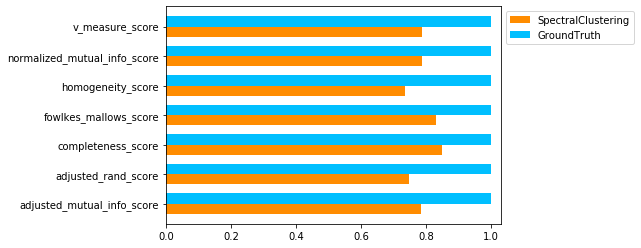

In [20]:
#Example how output sould looks like after the following command
_ = compare_clusterings(labels_true=protein["labels"],
                        SpectralClustering=labels_spectral,
                        GroundTruth=protein["labels"])

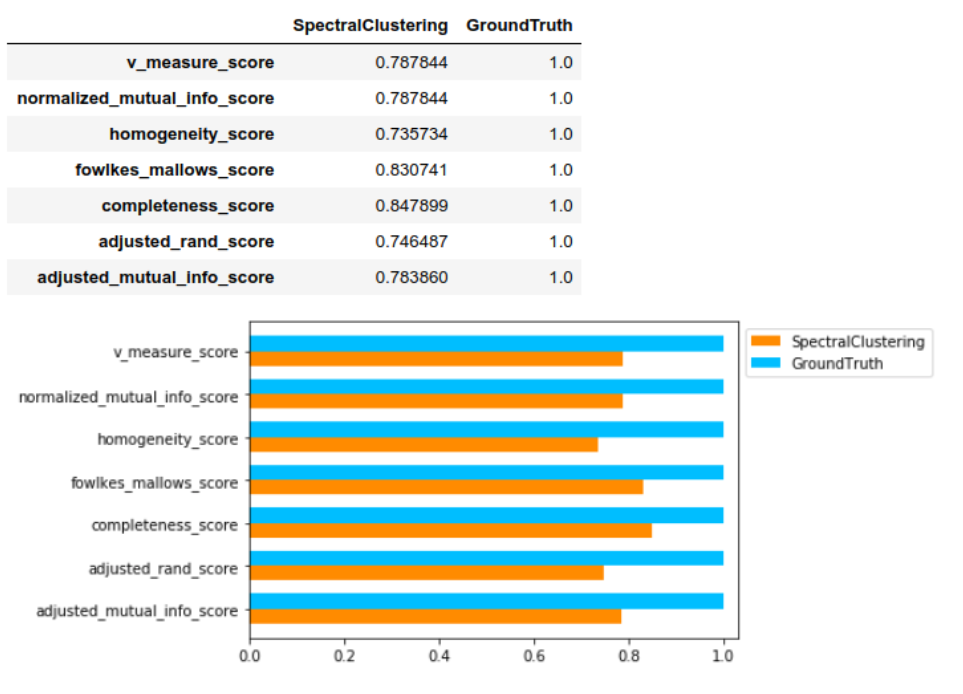

<h2 style="background-color:#f0b375;">
Section 5.0 
<span style=font-size:50%> Complete all problems in this (5.0.1-5.0.5) and previous sections to get a grade of 5.0 </span>
</h2>

In this section, you have to investigate the quality of clustering depending on various transformations from similarity data to dissimilarity data and compare results, in terms of different metrics.

<p style="background-color:#adebad;">
    As PairwiseClustering takes dissimilarities as input, we need to transform the similarity data from <b>Prodom</b> accordingly.<br>
    1. Run <b>fit_predict()</b> with all the transformations and parameters below. Run compare_clusterings for each set of parameter values for your <b>PairwiseClustering</b> algorithm. <br>
    2. Produce the output of <b>compare_clusterings()</b> for transformation families below. You should get 3 plots: 1st transformation family comparison, 2nd transformation family comparison, then comparison between of the best transformations of every family.<br>
<b>NOTE</b>: The best transformation in a family is the one that has the maximum average of all the scores above.
</p>

a=1 has the highest score for 7 different functions.
a=2 has the highest score for 0 different functions.
a=exp has the highest score for 0 different functions.
The winner is a=1.


,a=1,a=2,a=exp
v_measure_score,0.210681,0.150436,0.150436
normalized_mutual_info_score,0.210681,0.150436,0.150436
homogeneity_score,0.144479,0.094544,0.094544
fowlkes_mallows_score,0.525048,0.522191,0.522191
completeness_score,0.388861,0.367969,0.367969
adjusted_rand_score,0.061500,0.026986,0.026986
adjusted_mutual_info_score,0.209615,0.149813,0.149813


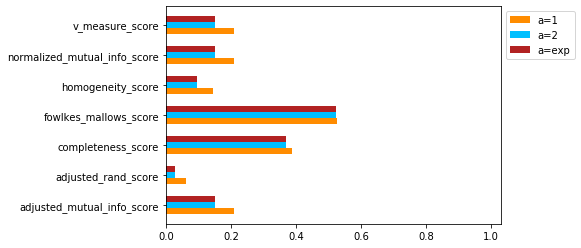

In [21]:
#Transformation family 1
# D = ((max(S) - S) / (max(S) - min(S))) ** 1
# D = ((max(S) - S) / (max(S) - min(S))) ** 2
# D = np.exp(((max(S) - S) / (max(S) - min(S))))

#Please add your code here
## Calculation of different dissimilarity matrices with different transformations of the similarity matrix
S  = prodom["similarity"]
D1 = ((np.max(S) - S) / (np.max(S) - np.min(S))) ** 1
D2 = ((np.max(S) - S) / (np.max(S) - np.min(S))) ** 2
D3 = np.exp((np.max(S) - S) / (np.max(S) - np.min(S)))
D  = [D1, D2, D3]

# Calculation of different cluster predictions with different dissimilarity matrices
labels1_SC = []
for i in range(3):
    SC = skl.cluster.SpectralClustering(n_clusters=4, random_state=42, affinity="precomputed")
    affinities = np.exp(- D[i] / 3) # SC takes positive affinities as input
    labels1_SC.append(SC.fit_predict(affinities))
    
# Print and plot the scores for different functions and different params
best_transform1_SC = compare_clusterings(labels_true=prodom["labels"],
                                         width = 0.2,
                                         SpectralClustering_a1=labels1_SC[0],
                                         SpectralClustering_a2=labels1_SC[1],
                                         SpectralClustering_aexp=labels1_SC[2])

a=1 has the highest score for 0 different functions.
a=1/2 has the highest score for 7 different functions.
a=log has the highest score for 0 different functions.
The winner is a=1/2.


,a=1,a=1/2,a=log
v_measure_score,0.182547,0.385255,0.376993
normalized_mutual_info_score,0.182547,0.385255,0.376993
homogeneity_score,0.121589,0.301001,0.292954
fowlkes_mallows_score,0.488250,0.562150,0.559588
completeness_score,0.366078,0.535012,0.528642
adjusted_rand_score,0.008838,0.202437,0.194235
adjusted_mutual_info_score,0.181983,0.384531,0.376254


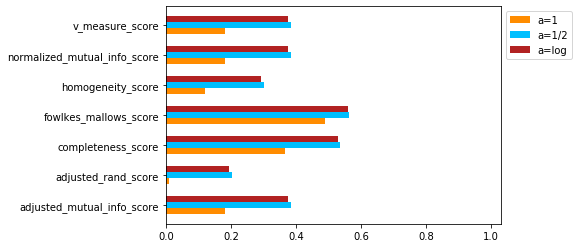

In [22]:
#Transformation family 2
# D = (max(S) / (1 + S - min(S))) ** 
# D = (max(S) / (1 + S - min(S))) ** 2
# D = np.log((max(S) / (1 + S - min(S))))

#Please add your code here
## Calculation of different dissimilarity matrices with different transformations of the similarity matrix
S  = prodom["similarity"]
D1 = ( np.max(S) / (1 + S - np.min(S)) ) ** 1
D2 = ( np.max(S) / (1 + S - np.min(S)) ) ** 0.5
D3 = np.log( np.max(S) / (1 + S - np.min(S)) )
D  = [D1, D2, D3]

# Calculation of different cluster predictions with different dissimilarity matrices
labels2_SC = []
for i in range(3):
    SC = skl.cluster.SpectralClustering(n_clusters=4, random_state=42, affinity="precomputed")
    affinities = np.exp(- D[i] / 3) # SC takes positive affinities as input
    labels2_SC.append(SC.fit_predict(affinities))
    
# Print and plot the scores for different functions and different params
best_transform2_SC = compare_clusterings(labels_true=prodom["labels"],
                                         width = 0.2,
                                         SpectralClustering_a1=labels2_SC[0],
                                         SpectralClustering_a1_2=labels2_SC[1],
                                         SpectralClustering_alog=labels2_SC[2])


<p style="background-color:#adebad;">
3. Provide a description of another reasonable transformation from similarity to dissimilarity and explain your choice.
</p>

In [24]:
## Convert best transform parameter to the index
def paramToIndex(param):
    if param=="a=1":
        return 0
    elif param=="a=1/2" or param=="a=2":
        return 1
    elif param=="a=exp" or param=="a=log":
        return 2

Best of Transform 1 has the highest score for 0 different functions.
Best of Transform 2 has the highest score for 7 different functions.
The winner is Best of Transform 2.


,Best of Transform 1,Best of Transform 2
v_measure_score,0.210681,0.385255
normalized_mutual_info_score,0.210681,0.385255
homogeneity_score,0.144479,0.301001
fowlkes_mallows_score,0.525048,0.562150
completeness_score,0.388861,0.535012
adjusted_rand_score,0.061500,0.202437
adjusted_mutual_info_score,0.209615,0.384531


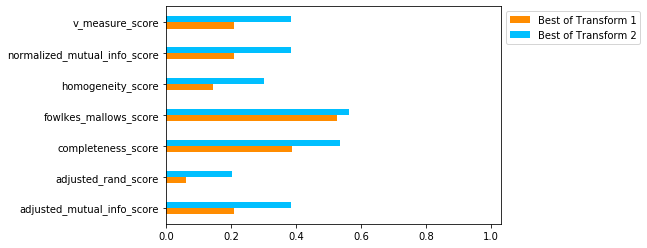

In [25]:
###### SPECTRAL CLUSTERING
## Comparison of the tranforms above using their best parameters
labels_transform1best_SC = labels1_SC[paramToIndex(best_transform1_SC)]
labels_transform2best_SC = labels2_SC[paramToIndex(best_transform2_SC)]

_ = compare_clusterings(labels_true=prodom["labels"],
                        width = 0.2,
                        SpectralClustering_aTransform1=labels_transform1best_SC,
                        SpectralClustering_aTransform2=labels_transform2best_SC)

<p style="background-color:#adebad;">
4. Implement your transformation. <br>
5. Compare your transformation using <b>compare_clusterings()</b> with the best from task 4.0.2. You should get one plot. <br>
</p>

a=1 has the highest score for 0 different functions.
a=2 has the highest score for 0 different functions.
a=exp has the highest score for 7 different functions.
The winner is a=exp.


,a=1,a=2,a=exp
v_measure_score,0.208276,0.126268,0.232029
normalized_mutual_info_score,0.208276,0.126268,0.232029
homogeneity_score,0.142113,0.096585,0.156427
fowlkes_mallows_score,0.524901,0.455521,0.532157
completeness_score,0.389709,0.182291,0.449060
adjusted_rand_score,0.086055,0.080498,0.088868
adjusted_mutual_info_score,0.207743,0.125743,0.231505


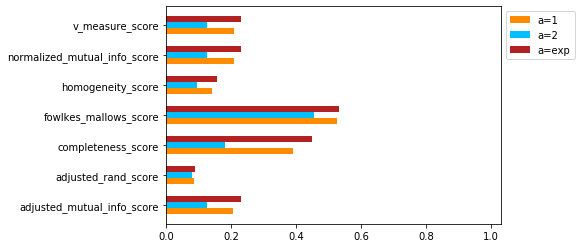

In [26]:
#Please add your code here
###### PAIRWISE CLUSTERING
def sigmoid(x):
    return 1 / (1 + np.exp(-x))

# D = (sigmoid(-(S-min(S))/(max(S)-min(S)))) ** a
# a = [1, 2, exp]

## Calculation of different dissimilarity matrices with different transformations of the similarity matrix
S  = prodom["similarity"]

D1 = (sigmoid(-(S-np.min(S))/(np.max(S)-np.min(S)))) ** 1
D2 = (sigmoid(-(S-np.min(S))/(np.max(S)-np.min(S)))) ** 2
D3 = np.exp(sigmoid(-(S-np.min(S))/(np.max(S)-np.min(S))))
D  = [D1, D2, D3]

# Calculation of different cluster predictions with different dissimilarity matrices
labels3_PC = []
for i in range(3):
    PC = PairwiseClustering()
    labels3_PC.append(PC.fit_predict(D[i]))
    
best_transform3_PC = compare_clusterings(labels_true=prodom["labels"],
                                         width = 0.2,
                                         PairwiseClustering_a1   = labels3_PC[0], 
                                         PairwiseClustering_a2   = labels3_PC[1],
                                         PairwiseClustering_aexp = labels3_PC[2])

In [30]:
###### PAIRWISE CLUSTERING
## Comparison of the given transforms and the additionally implemented transform using their best parameters
labels_transform1best_PC = labels1_PC[paramToIndex(best_transform1_PC)]
labels_transform2best_PC = labels2_PC[paramToIndex(best_transform2_PC)]
labels_transform3best_PC = labels3_PC[paramToIndex(best_transform3_PC)]

_ = compare_clusterings(labels_true=prodom["labels"],
                        width = 0.2,
                        PairwiseClustering_aTransform1=labels_transform1best_PC,
                        PairwiseClustering_aTransform2=labels_transform2best_PC,
                        PairwiseClustering_aTransform3=labels_transform3best_PC)

NameError: name 'labels1_PC' is not defined

<h2 style="background-color:#f0b375;">
Section 5.5 
<span style=font-size:50%> Complete all problems in this (5.5.1-5.5.6) and previous sections to get a grade of 5.5 </span>
</h2>

In this section, you have to  implement and calculate cost function and investigate the stability of pairwise clustering in terms of obtained values of the clustering cost function, providing experiments for different random seeds and number of clusters.

<p style="background-color:#adebad;">
1. Implement the cost function of the <b>PairwiseClustering class</b>. <br>
2. Compute the cost function for <b>Protein</b> data. <br>
3. Calculate the execution time. <br>
</p>

In [31]:
%%time
PC = PairwiseClustering()
labels_pair = PC.fit_predict(protein["dissimilarity"])
cost = PC.cost(protein["dissimilarity"], PC.M)

CPU times: user 1.09 s, sys: 35.3 ms, total: 1.13 s
Wall time: 311 ms


<p style="background-color:#adebad;">
4. Re-run <b>fit_predict()</b> with 10 different random seeds and plot the distribution of clustering costs as shown in Figure 1 of reference [1]. <br>
5. Visualize the histograms of obtained cost functions.You should get 2 histograms; one for <b>Prodom</b> and the other for <b>Protein</b> data. Hint: use <b>matplotlib.plot.hist()</b> to plot histograms of cost functions.
</p>

<p style="background-color:#adebad;">
<b>NOTE:</b> For ProDom data use the best transformation from section 5.0 to transform similiarities to dissimiliraties. 
</p>

In [34]:
# data = [protein, prodom]
# Use the best transform from Problem 3 to transform similarities
# other parameters are default
S_prodom  = prodom["similarity"]
D_prodom  = np.log( np.max(S) / (1 + S - np.min(S)) )
D_protein = protein["dissimilarity"]
n_seeds   = 10
data      = [D_protein, D_prodom]
costs1    = np.zeros((len(data), n_seeds))
for j in range(len(data)):
    for i in range(n_seeds):
        PC = PairwiseClustering(random_state=i)
        PC.fit_predict(data[j])
        costs1[j, i] = PC.cost(data[j], PC.M)

<p style="background-color:#adebad;">
6. Perform the experiment for all the settings listed below, and visualize the results properly. You should get 4 histograms; one for each different number of clusters. <br>
</p>

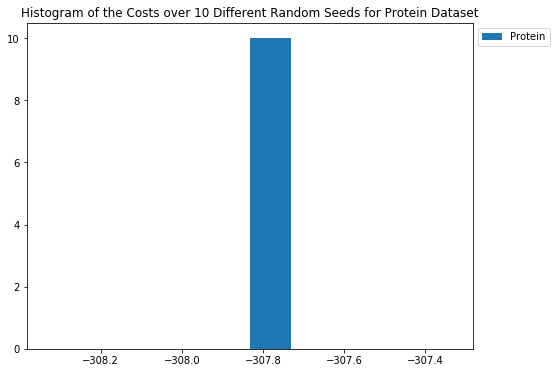

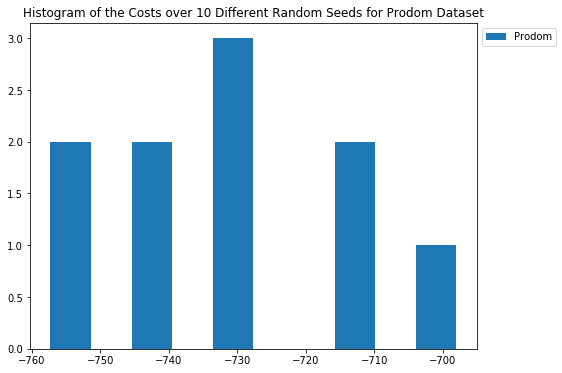

In [36]:
ds  = ["Protein", "Prodom"]
for i in range(costs1.shape[0]):
    fig = plt.figure(figsize=(8,6))
    plt.hist(costs1[i, :], label=ds[i])
    plt.legend(bbox_to_anchor=(1, 1), loc='upper left', ncol=1)
    plt.title("Histogram of the Costs over 10 Different Random Seeds for " + ds[i] + " Dataset")
    plt.show()

<h2 style="background-color:#f0b375;">
Section 6.0
<span style=font-size:50%> Complete all problems (6.0.1-6.0.5) in this and previous sections to get a grade of 6.0 </span>
</h2>



In this section, you must implement an EM-like procedure to obtain data embeddings in the Euclidean space, while visualizing these clusters on a 2d plane.

<p style="background-color:#adebad;">
1. Provide a description of the EM-like procedure for pairwise clustering in case we want to get embeddings (algorithm III in reference [1]). <br>
</p>

In [ ]:
#Provide your answer here

<p style="background-color:#adebad;">
2.  Implement Algorithm III in [1], which explains how to compute an embedding within the EM-like procedure. In code <b>fit_predict()</b>: the <b>embed == True</b> part.<br>
3. Predict a clustering for the <b>Protein</b> data.<br>
4. Calculate the execution time.<br>
</p>

In [ ]:
np.random.seed(111)
#PCE = PairwiseClustering(embed=True,...)

#Please add your code here

<p style="background-color:#adebad;">
5. Cluster the Protein data and properly visualize the embedding for <b>n_components=2</b>. Hint: <b>use matplotlib.pyplot.scatter()</b> to plot clusters on 2d plane using different colors for different clusters.
</p>

In [ ]:
#Please add your code here

## Comments

We hope you found this exercise instructive.

Feel free to leave comments below, we will read them carefully.